## Imports

In [1]:
import numpy as np
import sys
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import matplotlib.cm as cm

## Load the data

In [2]:
ml_args_raster_low_res = './raster/low_res'
ml_args_raster_high_res = './raster/high_res'
ml_args_count = 13597

def ml_raster_import( ml_path ):

    # check consistency #
    if ( not os.path.exists( ml_path ) ):

        # send message #
        sys.exit( 'turing : error : unable to access raster' )

    # retrieve raster size #
    ml_size = os.path.getsize( ml_path )

    # compute raster width #
    ml_width = int( round( ml_size ** ( 1.0 / 3.0 ) ) )

    # import raster data #
    with open( ml_path, 'rb' ) as ml_file:

        # read raster bytes #
        ml_byte = ml_file.read( ml_size )

    # convert to numpy array #
    ml_data = np.frombuffer( ml_byte, dtype=np.uint8 )

    # return raster array #
    return ml_data.reshape( ml_width, ml_width, ml_width )

##
##  script - raster convertion
##

def ml_raster_convert( ml_raster ):

    # check consistency #
    if ( ( ml_raster.shape[0] != ml_raster.shape[1] ) or ( ml_raster.shape[0] != ml_raster.shape[2] ) ):

        # send message #
        sys.exit( 'turing : error : raster not consistent' )

    # retrieve raster width #
    ml_width = ml_raster.shape[0]

    # initialise array #
    ml_data = np.empty( ( 0, 3 ), dtype=np.uint8 )

    # parsing raster array #
    for ml_x in range( ml_width ):

        # parsing raster array #
        for ml_y in range( ml_width ):

            # parsing raster array #
            for ml_z in range( ml_width ):

                # check raster element #
                if ( ml_raster[ml_x, ml_y, ml_z] != 0 ):

                    # compute element coordinates #
                    ml_r = ml_x / ml_width
                    ml_s = ml_y / ml_width
                    ml_t = ml_z / ml_width

                    # append element #
                    ml_data = np.append( ml_data, np.array( [[ ml_r, ml_s, ml_t ]] ), axis=0 )

    # return converted array #
    return( ml_data )

In [3]:
def get_ml_data(ml_args_raster):

    ml_data = []
    
    for raster_id in range(2000): # on 13597
        
        raster_path = ml_args_raster + '/raster-{:06d}.ras'.format(raster_id)
    
        # import raster array #
        data = ml_raster_import(raster_path)

        # convert raster to point set #
        #data = ml_raster_convert(data)
    
        ml_data.append(data)
        
    return ml_data

ml_data_low_res = get_ml_data(ml_args_raster_low_res)
ml_data_high_res = get_ml_data(ml_args_raster_high_res)

## Define the loss function

In [4]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector. This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    # Discretize prediction at threshold = 0.5
    #length = len(pred[0][0])
    #zeros = torch.zeros(length, length, length)
    #ones = torch.ones(length, length, length)
    #pred_ = torch.where(pred >= 0.5, pred, zeros)
    #pred_ = torch.where(pred_ < 0.5, pred_, ones)
    
    pred_grad, target_grad = pred, target
    pred_grad = pred_grad.detach().numpy()
    target_grad = target_grad.detach().numpy()
    
    pred_grad = np.gradient(pred_grad)
    target_grad = np.gradient(target_grad)
    
    mu_ = (np.linalg.norm((target_grad[0] - pred_grad[0])**2) + \
    np.linalg.norm((target_grad[1] - pred_grad[1])**2) + \
    np.linalg.norm((target_grad[2] - pred_grad[2])**2))*1e-4
    
    return abs(1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )) + mu_

## Build Torch Tensors from the data

In [5]:
class CloudPointDataset(Dataset):

    def __init__(self, thin_dataset, thick_dataset, train, transform=None):
        """
        Args:
            mat_file (string): Path to the mat file with the data
            train (boolean): Is it the training data or the test data
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.X = thin_dataset
        self.Y = thick_dataset
        self.X = np.asarray(self.X).astype(float)
        #self.X = np.expand_dims(self.X, axis=1)
        self.Y = np.asarray(self.Y).astype(float)
        #self.Y = np.expand_dims(self.Y, axis=1)
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(self.X, self.Y, test_size=0.3, random_state=1)
        self.Xtrain, self.Xtest = Xtrain, Xtest
        self.Ytrain, self.Ytest = Ytrain, Ytest
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return (self.Xtrain.shape[0])
        else:
            return (self.Xtest.shape[0])

    def __getitem__(self, idx):
        
        if self.train:
            sample = {'image': self.Xtrain[idx,:], 'label': self.Ytrain[idx,:]}
        else:
            sample = {'image': self.Xtest[idx,:], 'label': self.Ytest[idx,:]}
            
        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        raster, label = sample['image'], sample['label']
        raster = torch.from_numpy(raster).float()
        raster = raster.expand(1, 16, 16, 16)
        return {'image': raster, 'label': label}

In [7]:
trainset = CloudPointDataset(ml_data_low_res, ml_data_high_res, train=True, transform = ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1, shuffle=True, num_workers=0)

testset = CloudPointDataset(ml_data_low_res, ml_data_high_res, train=False, transform=ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle=False, num_workers=0)

## Define the model & CNN architecture

In [8]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, 3, padding = 1, stride = 1)
        self.conv2 = nn.Conv3d(32, 32, 3, padding = 1, stride = 1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding = 1, stride = 1)
        self.conv4 = nn.Conv3d(64, 64, 3, padding = 1, stride = 1)
        self.conv5 = nn.Conv3d(64, 1, 3, padding = 1, stride = 1)
        self.BN = nn.BatchNorm3d(num_features = 32)
        
        #self.replication_padding = nn.ReplicationPad3d(2)
        #self.zero_padding = nn.ConstantPad3d(2, 0)
        #self.depadding = nn.ReplicationPad3d(-4)
        
    def forward(self, x):

        x_ = []
        #x = self.replication_padding(x)
        #x = self.zero_padding(x)
        
        x = self.conv1(x)
        x = self.BN(x)
        x = F.relu(x)
        x_.append(x)
        
        # 2 residual blocks
        for i in range(6):
            x = self.conv2(x)
            x = self.BN(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = self.BN(x)
            x = x + x_[-1]
            x_.append(x)
        
        x = self.conv2(x)
        x = self.BN(x)
        x = x + x_[0]
        
        # Upsampling blocks
        x = self.conv3(x)
        x = F.relu(x)
        x = nn.functional.interpolate(x, size = (24, 24, 24), mode='trilinear')
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x) 
        x = nn.functional.interpolate(x, size = (32, 32, 32), mode='trilinear')
        x = self.conv4(x)
        x = F.relu(x)
        
        x = self.conv5(x)
        #x = self.depadding(x)
        
        
        return x

net = Net()

In [9]:
criterion = nn.BCEWithLogitsLoss() #nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.8)

# Train the model

In [10]:
y_hat, y, x = [], [], []

for epoch in range(5):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        images, labels = data['image'], data['label'].float() #.long() #.float()
        
        # wrap them in Variable
        images, labels = Variable(images), Variable(labels)

        # clear the gradients of the variables
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        outputs = np.squeeze(outputs, axis=0)
        labels = np.squeeze(labels, axis=0)
        
        #outputs = np.expand_dims(outputs, axis=1)
        y_hat.append(outputs)
        x.append(images)
        y.append(labels)
                        
        #loss = dice_loss(outputs, labels)
        
        #print(len(labels), len(labels[0]), len(labels[0][0]), len(labels[0][0][0]))
        #print(len(outputs), len(outputs[0]), len(outputs[0][0]), len(outputs[0][0][0]))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]

        # print every mini-batches
        if i+1 == 7:
            print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss))

print('Finished Training')

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,     7] loss: 4.739
[2,     7] loss: 0.577
[3,     7] loss: 0.390
[4,     7] loss: 0.338
[5,     7] loss: 0.319
Finished Training


# Print the output

In [11]:
print(len(y), len(y[0]), len(y[0][0]), len(y[0][0][0]))#, len(y[0][0][0][0]))

7000 32 32 32


In [12]:
print(len(y_hat), len(y_hat[0]), len(y_hat[0][0]), len(y_hat[0][0][0]))#, len(y[0][0][0][0]))

7000 32 32 32


In [13]:
def print_x(y, n = 0):
    
    Y = y[n][0].detach().numpy()
    Y = ml_raster_convert(Y)
    
    # create figure #
    ml_figure = plt.figure()

    # create figure sub-plot #
    ml_plot = ml_figure.add_subplot(111, projection='3d' )

    ml_plot.scatter(Y[:,2], Y[:,1], Y[:,0], s=8, marker='.')
    # setting axis aspect ratio #
    ml_plot.set_aspect( 'equal' )

    # setting axis limits #
    ml_plot.set_xlim( 0.0, 1.0 )
    ml_plot.set_ylim( 0.0, 1.0 )
    ml_plot.set_zlim( 0.0, 1.0 )

    # setting plot initial camera view #
    ml_plot.view_init( elev=66, azim=225 )
        
    return True

In [14]:
def print_y(y, n = 0):
    
    Y = y[n].detach().numpy()

    Y[Y < 0.5] = 0
    Y[Y >= 0.5] = 1
    Y = ml_raster_convert(Y)
    
    # create figure #
    ml_figure = plt.figure()

    # create figure sub-plot #
    ml_plot = ml_figure.add_subplot(111, projection='3d' )

    ml_plot.scatter(Y[:,2], Y[:,1], Y[:,0], s=8, marker='.')
    # setting axis aspect ratio #
    ml_plot.set_aspect( 'equal' )

    # setting axis limits #
    ml_plot.set_xlim( 0.0, 1.0 )
    ml_plot.set_ylim( 0.0, 1.0 )
    ml_plot.set_zlim( 0.0, 1.0 )

    # setting plot initial camera view #
    ml_plot.view_init( elev=66, azim=225 )
        
    return True

In [71]:
%matplotlib
#%matplotlib qt
%matplotlib inline

Using matplotlib backend: Qt5Agg


In [100]:
n = 2007

True

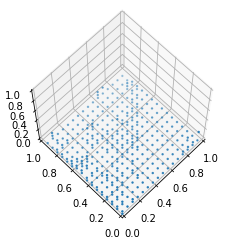

In [101]:
print_x(x[n])

True

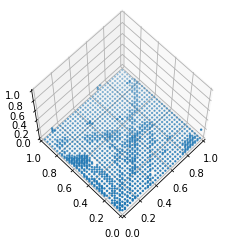

In [102]:
print_y(y, n)

True

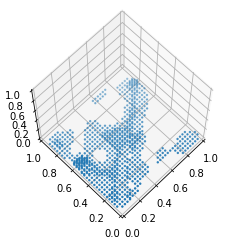

In [103]:
print_y(y_hat, n)